In [144]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

In [122]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [123]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [124]:
print(f"Train Image Size: {train_images.shape}")
print(f"Train label Size: {train_labels.shape}")

print(f"Test Image Size: {test_images.shape}")
print(f"Test label Size: {test_labels.shape}")

Train Image Size: (60000, 28, 28)
Train label Size: (60000,)
Test Image Size: (10000, 28, 28)
Test label Size: (10000,)


## Data Exploration

In [125]:
print(f"Min value: {train_images[0].min()}\nMax Value: {train_images[0].max()}")

Min value: 0
Max Value: 255


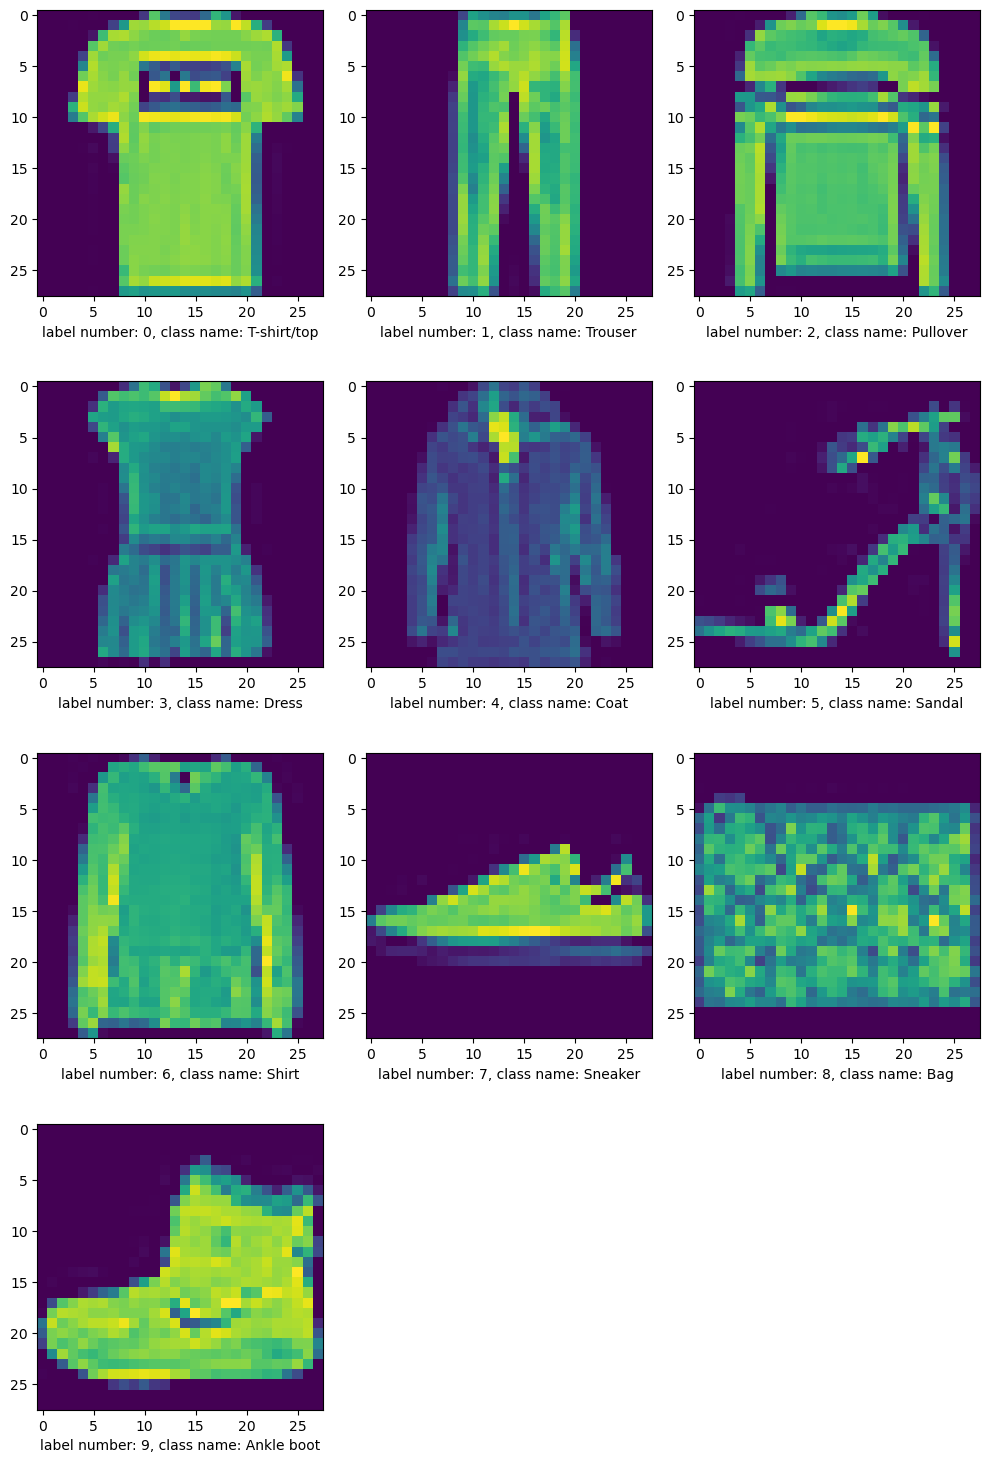

In [126]:
# Plotting images for each labels
unique_values, indices = np.unique(train_labels, return_index=True)

fig, axs= plt.subplots(4, 3, figsize=(10, 15))
axs= axs.flatten()
for (unique_value, index) in (zip(unique_values, indices)):
    axs[unique_value].imshow(train_images[index])
    axs[unique_value].set_xlabel(f"label number: {unique_value}, class name: {class_names[unique_value]}")

# Leave the last two plots empty
for i in range(10, 12):  # Optional: Remove axes
    axs[i].axis('off')


plt.tight_layout()
plt.show()

In [127]:
#Normalization in the range of [0 - 1]
train_images = train_images / 255.0

test_images = test_images / 255.0

In [128]:
# One hot encoding, 
encoder = OneHotEncoder(sparse_output= False)

train_labels_onehot = encoder.fit_transform(train_labels.reshape(-1, 1))
test_labels_onehot = encoder.transform(test_labels.reshape(-1, 1))

- If we want to use one hot encoded label data then we must use **Categorical Cross Entropy** as loss function. 
- If we use normal label data then we can use **Sparce Categorical Cross Entropy** as loss function.

In [129]:
print(train_labels.reshape(-1, 1).shape)
print(train_labels_onehot.shape)

(60000, 1)
(60000, 10)


# Model Building And Evaluation:

In [130]:
# Checking whether GPU or CPU used for model training
gpu_devices = tf.config.list_physical_devices('GPU')

if not gpu_devices:
    print("TensorFlow is using the CPU.")
else:
    print(f"TensorFlow is using the following GPU(s): {gpu_devices}")

TensorFlow is using the following GPU(s): [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [145]:
# This is done for the reproducability of the model
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

## Common Methods Used In Model Evaluations

In [132]:
# Method to plot train and validation accuracy and loss over epoches.
def PlotTrainAndValidationAccuracyAndLoss(nn_model_history: tf.keras.callbacks.History, model_name: str):
    fig, axs = plt.subplots(1, 2, figsize=(20, 5))
    sns.lineplot(x=np.array(nn_model_history.epoch) + 1, y= nn_model_history.history['accuracy'], label='Train', ax = axs[0])
    sns.lineplot(x=np.array(nn_model_history.epoch) + 1, y= nn_model_history.history['val_accuracy'], label='Validation', ax = axs[0])
    axs[0].set_title(f'{model_name} accuracy')
    axs[0].set_ylabel('accuracy')
    axs[0].set_xlabel('epoch')
    axs[0].legend(loc='upper left')

    sns.lineplot(x=np.array(nn_model_history.epoch) + 1, y= nn_model_history.history['loss'], label='Train', ax = axs[1])
    sns.lineplot(x=np.array(nn_model_history.epoch) + 1, y= nn_model_history.history['val_loss'], label='Validation', ax = axs[1])
    axs[1].set_title(f'{model_name} loss')
    axs[1].set_ylabel('loss')
    axs[1].set_xlabel('epoch')
    axs[1].legend(loc='upper left')

    plt.tight_layout()
    plt.show()

In [141]:
#Model Evaluation function
def EvaluateNeuralNetworkModel(nn_model : tf.keras.Sequential, test_images: np.ndarray, test_labels: np.ndarray, test_labels_onehot: np.ndarray, model_name: str):
    model_test_loss, model_test_acc = nn_model.evaluate(test_images,  test_labels_onehot, verbose=2)

    print(f'\nTest accuracy for {model_name}: {model_test_acc:.4f}\n')
    print(f"Test loss for {model_name}: {model_test_loss:.4f}\n")
    
    model_prediction_result_softmax= nn_model.predict(test_images,batch_size= 32)

    model_test_label_pred = np.argmax(model_prediction_result_softmax, axis=1)  # Predicted labels

    print(f"first 10 predicted outputs: {model_test_label_pred[:10]}\n")
    print(f"first 10 true outpurs: {test_labels[:10]}\n")

    # Print a classification report for neural network classification model
    model_classification_report = (classification_report(test_labels, model_test_label_pred))
    print(f"Classification report for {model_name} :\n{model_classification_report}")

    # Print a confusion matrix for neural network on test dataset

    snn1_confusion_matrix= (confusion_matrix(test_labels, model_test_label_pred))

    sns.heatmap(data= snn1_confusion_matrix,fmt='g', annot= True, cmap= "crest")
    plt.title(f"Confusion Matrix for the {model_name} on test dataset")
    plt.tight_layout()
    plt.xlabel("Predicted Values")
    plt.ylabel("Actual Values")
    plt.show()

    return model_prediction_result_softmax
    

In [ ]:
# Model committee by averaging prediction of models: 
def ModelCommitteeAnalysis(model_result_softmax_list: list, test_labels: np.ndarray, model_name: str, is_object_return= False):
    model_committee_softmax = np.mean(model_result_softmax_list, axis= 0)
    model_committee_test_label_pred = np.argmax(model_committee_softmax, axis=1)  # Predicted labels

    loss = tf.keras.losses.CategoricalCrossentropy()(test_labels_onehot, model_committee_softmax).numpy()
    accuracy = accuracy_score(test_labels, model_committee_test_label_pred)

    print(f"Loss for the {model_name} neural network committee on test dataset: {loss:.4f}")
    print(f"Accuracy for the {model_name} neural network committee on test dataset: {accuracy:.4f}")

    print(f"first 10 predicted outputs using committee by averaging predictions: {model_committee_test_label_pred[:10]}\n")
    print(f"first 10 true outputs: {test_labels[:10]}\n")

    # Print a classification report for committee of shallow neural network classification models
    model_committee_classification_report = (classification_report(test_labels, model_committee_test_label_pred))
    print(model_committee_classification_report)

    # Print a confusion matrix for committee of neural network on test dataset

    model_committee_confusion_matrix= (confusion_matrix(test_labels, model_committee_test_label_pred))

    sns.heatmap(data= model_committee_confusion_matrix,fmt='g', annot= True, cmap= "vlag")
    plt.title(f"Confusion Matrix for the {model_name} neural network committee on test dataset")
    plt.tight_layout()
    plt.xlabel("Predicted Values")
    plt.ylabel("Actual Values")
    plt.show()

    if(is_object_return):
        return model_committee_softmax, model_committee_test_label_pred


## Shallow Neural Network

### shallow neural network 1

**Model Architecture**:
- 28 * 28 pixels images are provided as input to the model. 
- First step is to flatten the 2D inputs into 1D input parameters. 
- After Flatten, It is fed to the fist Dense layer. It contains 128 neurons and **relu** as activation function.
- It has output layers with 10 neurons. **Softmax** activation function is used in output layer.
- For the optimization of the model, We are using **ADAM** optimizer.
- For the loss calculation of the model, We are using **Categorical** Cross Entropy*.
- As an additional performance metrices, we are using **Accuracy** to evaluate the model during training. 

In [ ]:
#Shallow Neural Network Model 1
shallow_nn_model1 = tf.keras.Sequential([
    tf.keras.layers.Input(shape= (28, 28)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

shallow_nn_model1.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy,
              metrics=['accuracy'])

shallow_nn1_history = shallow_nn_model1.fit(
    train_images, 
    train_labels_onehot, 
    epochs=100, 
    validation_split= 0.2, 
    batch_size= 32)

Epoch 1/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.7718 - loss: 0.6569 - val_accuracy: 0.8503 - val_loss: 0.4244
Epoch 2/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8595 - loss: 0.3960 - val_accuracy: 0.8580 - val_loss: 0.3949
Epoch 3/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8753 - loss: 0.3483 - val_accuracy: 0.8692 - val_loss: 0.3667
Epoch 4/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8847 - loss: 0.3189 - val_accuracy: 0.8759 - val_loss: 0.3556
Epoch 5/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8902 - loss: 0.2982 - val_accuracy: 0.8754 - val_loss: 0.3491
Epoch 6/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8965 - loss: 0.2817 - val_accuracy: 0.8764 - val_loss: 0.3483
Epoch 7/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9008 - loss: 0.2682 - val_accuracy: 0.8824 - val_loss: 0.3367
Epoch 8/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9050 - loss: 

Model is trained over 100 epoches and 20% of the training dataset is separated as the validation set. For this model, We used batch size of 32. 

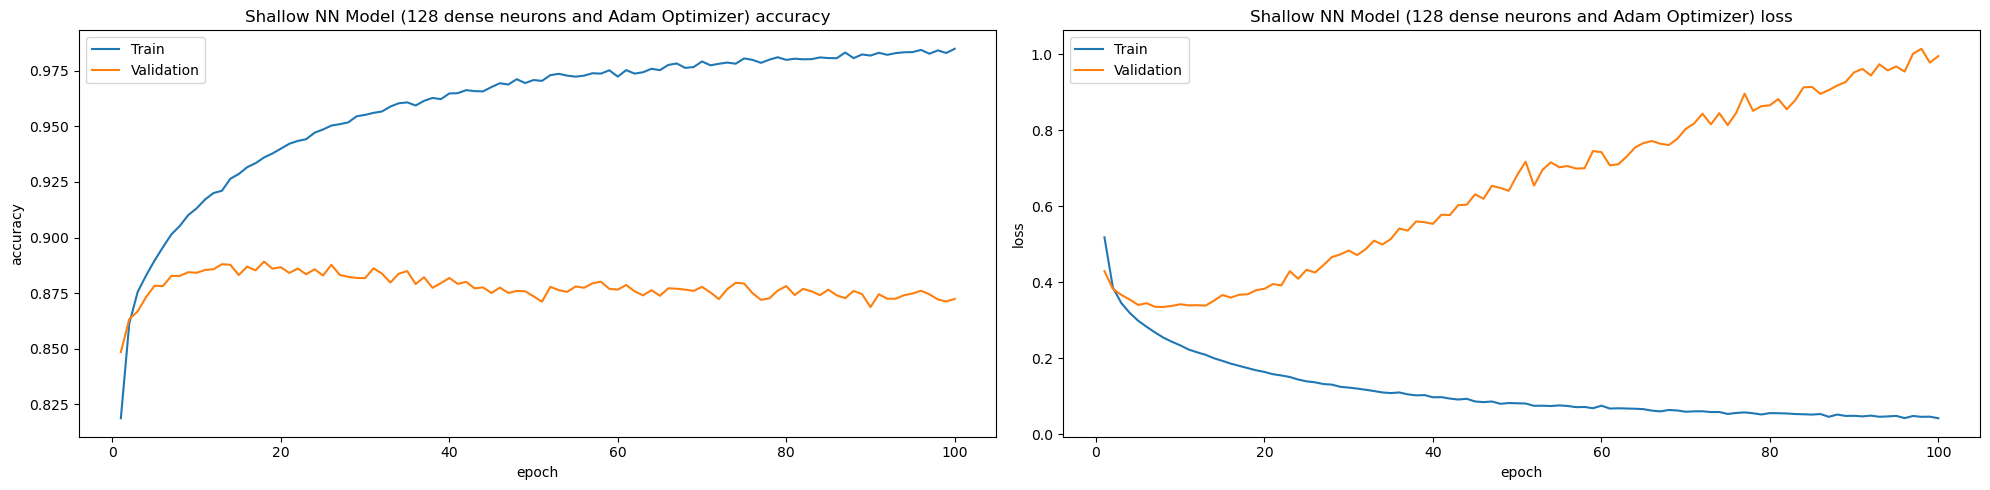

In [80]:
PlotTrainAndValidationAccuracyAndLoss(shallow_nn1_history, "Shallow NN Model (128 dense neurons and Adam Optimizer)")


Above plot shows the change in accuracy and loss of both training data and validation data over the epoches. 

- **Accuracy**
  - If we look into the accracy of the train data set, it keeps improving over 100 epoches and it reached to the accuracy of 0.9852.
  - But in validation data set, accuracy increased initially but later it did not change over the epoches and maintain the validation accuracy of 0.8698. 
  - There is huge gap in training accuracy and validation accuracy. This is the case of over fitting. Model is able to predict the output accuratly on training dataset but not on validation dataset. 

- **Categorical Cross EntropyLoss**
  - Training loss started from the value of around 0.6569 and it kept decreasing and after around 40 epochs, loss started maintaing similar loss values. And finally at 100 epoches it showed the loss of 0.0425 for training data set. 
  - Similary For the validation dataset, loss values initially decreases but after few epochs it started increasing and after 100 epochs, it had the validation loss of 1.0076. Validation loss has huge deviation from training loss which showed that model is facing the problem of overfitting.

313/313 - 1s - 3ms/step - accuracy: 0.8627 - loss: 1.1343

Test accuracy for Shallow NN 1: 0.8627

Test loss for Shallow NN 1: 1.1343

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
first 10 predicted outputs: [9 2 1 1 0 1 4 6 5 7]

first 10 true outpurs: [9 2 1 1 6 1 4 6 5 7]

Classification report for Shallow NN 1 :
              precision    recall  f1-score   support

           0       0.87      0.69      0.77      1000
           1       0.98      0.97      0.98      1000
           2       0.80      0.75      0.77      1000
           3       0.91      0.83      0.87      1000
           4       0.80      0.78      0.79      1000
           5       0.98      0.96      0.97      1000
           6       0.56      0.79      0.65      1000
           7       0.92      0.97      0.94      1000
           8       0.96      0.97      0.96      1000
           9       0.97      0.94      0.95      1000

    accuracy                           0.86     10000
   macro avg       0.88      0.86   

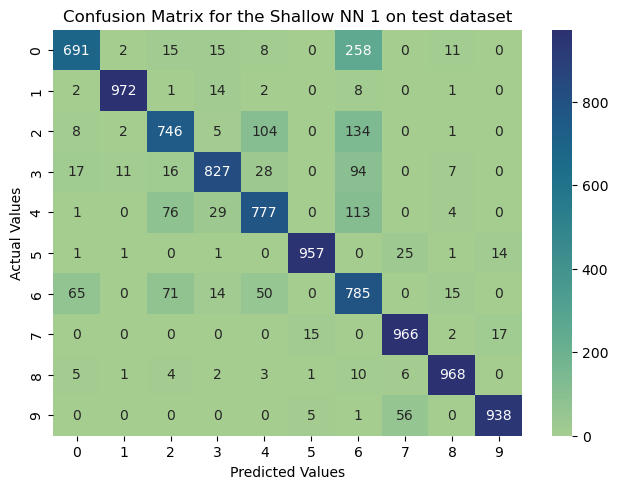

In [142]:
snn1_prediction_result_softmax = EvaluateNeuralNetworkModel(shallow_nn_model1, test_images, test_labels, test_labels_onehot, "Shallow NN 1")

Class 6 "Shirt" is misclassified for the most of the time. It is mostly confused with class 0 "T-shirt/top" and then with class 2 "Pullover" and then with class 5 "Coat".

### Shallow Neural Network Model 2

In this model, 
- We used 256 neurons in dense layer with **relu** activation function. 
- We used Adam Optimizer with initial learning rate of 0.001 as the optimization function. 
- While training model we use the batch size of 64. 

Other than that all architectural design is similar to the Shallow Neural Network 1. 

In [ ]:
#Shallow Neural Network Model 2
shallow_nn_model2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape= (28, 28)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

shallow_nn_model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy,
              metrics=['accuracy'])

shallow_nn2_history = shallow_nn_model2.fit(
    train_images, 
    train_labels_onehot, 
    epochs=100, 
    validation_split= 0.2, 
    batch_size= 64)

Epoch 1/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.7709 - loss: 0.6526 - val_accuracy: 0.8515 - val_loss: 0.4144
Epoch 2/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8581 - loss: 0.4001 - val_accuracy: 0.8693 - val_loss: 0.3761
Epoch 3/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8757 - loss: 0.3493 - val_accuracy: 0.8745 - val_loss: 0.3580
Epoch 4/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8847 - loss: 0.3205 - val_accuracy: 0.8773 - val_loss: 0.3555
Epoch 5/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8907 - loss: 0.2988 - val_accuracy: 0.8802 - val_loss: 0.3514
Epoch 6/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8970 - loss: 0.2821 - val_accuracy: 0.8819 - val_loss: 0.3521
Epoch 7/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9025 - loss: 0.2659 - val_accuracy: 0.8802 - val_loss: 0.3585
Epoch 8/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9081 - loss: 0.2518 - val_accu

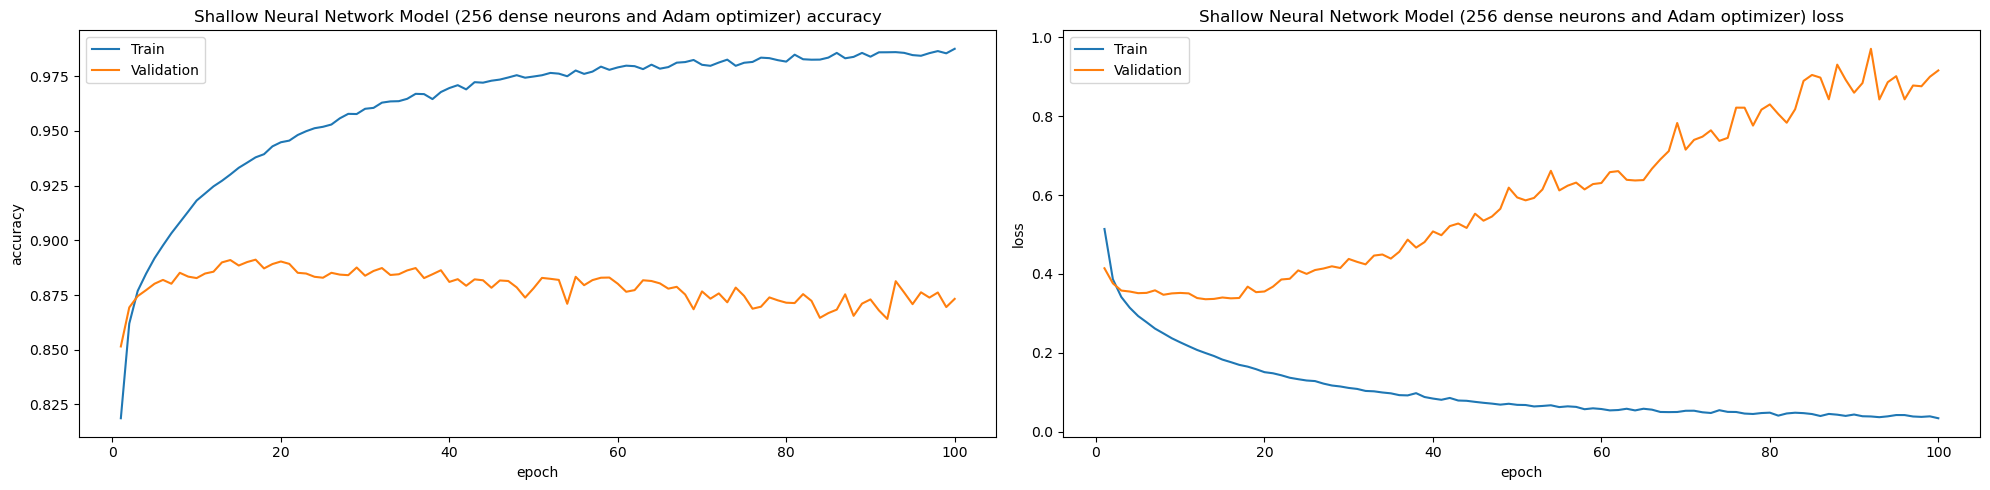

In [147]:
PlotTrainAndValidationAccuracyAndLoss(shallow_nn2_history, "Shallow Neural Network Model (256 dense neurons and Adam optimizer)")

Above plot shows the change in accuracy and loss of both training data and validation data over the epoches. 

- **Accuracy**
  - Training Accuracy: 0.9888.
  - Validation Accuracy of 0.8733. 
  - Overfitting 

- **Categorical Cross EntropyLoss**
  - Training Loss: 0.0324
  - Validation Loss: 0.9158

313/313 - 1s - 2ms/step - accuracy: 0.8755 - loss: 0.9386

Test accuracy for Shallow NN 2: 0.8755

Test loss for Shallow NN 2: 0.9386

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
first 10 predicted outputs: [9 2 1 1 6 1 4 6 5 7]

first 10 true outpurs: [9 2 1 1 6 1 4 6 5 7]

Classification report for Shallow NN 2 :
              precision    recall  f1-score   support

           0       0.89      0.69      0.78      1000
           1       0.97      0.98      0.98      1000
           2       0.79      0.81      0.80      1000
           3       0.90      0.89      0.89      1000
           4       0.85      0.71      0.78      1000
           5       0.97      0.97      0.97      1000
           6       0.61      0.81      0.69      1000
           7       0.95      0.96      0.95      1000
           8       0.96      0.97      0.97      1000
           9       0.96      0.96      0.96      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88   

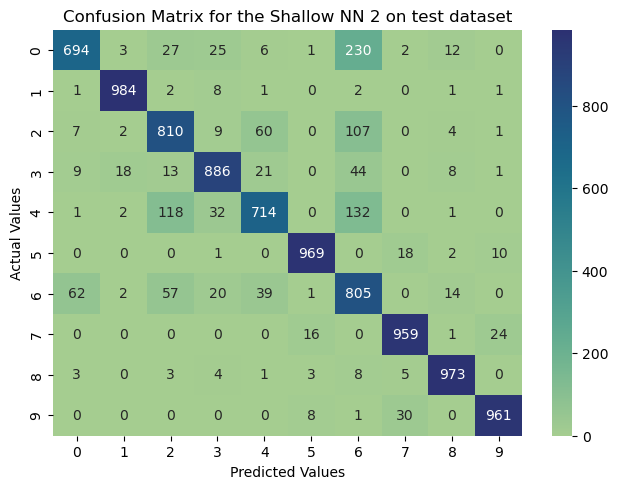

In [151]:
snn2_prediction_result_softmax = EvaluateNeuralNetworkModel(shallow_nn_model2, test_images, test_labels, test_labels_onehot, "Shallow NN 2")

### Shallow Neural Network Model 3

In this model, 
- I splitted the one dense layer of 256 neurons into the 2 dense layers with 128 neurons in each layer.
- Optimization function is also changed from Adam Optimizer to the SGD Optimizer. 

In [ ]:
#Shallow Neural Network Model 3
shallow_nn_model3 = tf.keras.Sequential([
    tf.keras.layers.Input(shape= (28, 28)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
shallow_nn_model3.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.005),
              loss=tf.keras.losses.CategoricalCrossentropy,
              metrics=['accuracy'])

shallow_nn3_history = shallow_nn_model3.fit(train_images, train_labels_onehot, epochs=100, validation_split= 0.2, batch_size= 64)

Epoch 1/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5095 - loss: 1.6236 - val_accuracy: 0.7327 - val_loss: 0.7943
Epoch 2/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7490 - loss: 0.7521 - val_accuracy: 0.7842 - val_loss: 0.6458
Epoch 3/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7918 - loss: 0.6269 - val_accuracy: 0.8060 - val_loss: 0.5815
Epoch 4/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8098 - loss: 0.5671 - val_accuracy: 0.8177 - val_loss: 0.5442
Epoch 5/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8199 - loss: 0.5306 - val_accuracy: 0.8233 - val_loss: 0.5191
Epoch 6/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8276 - loss: 0.5055 - val_accuracy: 0.8278 - val_loss: 0.5006
Epoch 7/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8336 - loss: 0.4868 - val_accuracy: 0.8320 - val_loss: 0.4864
Epoch 8/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8386 - loss: 0.4722 - val_accu

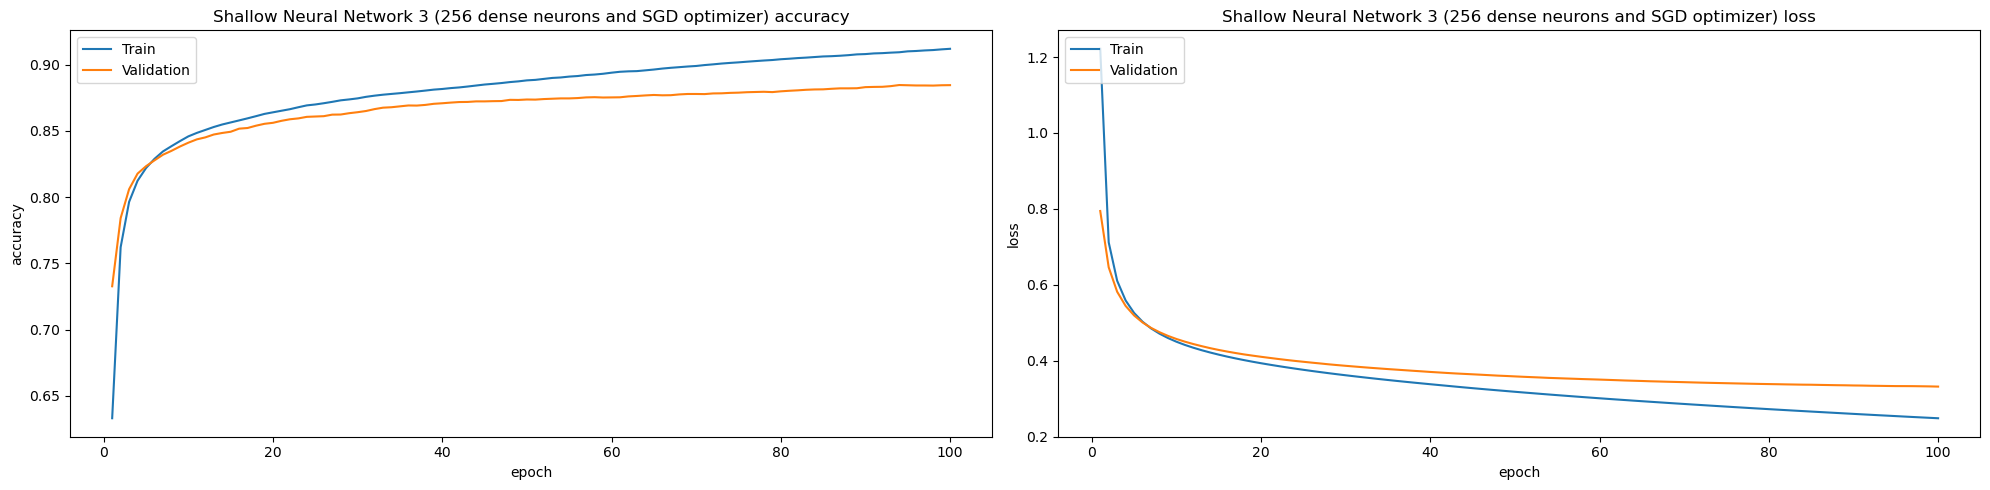

In [162]:
PlotTrainAndValidationAccuracyAndLoss(shallow_nn3_history, "Shallow Neural Network 3 (256 dense neurons and SGD optimizer)")

Above plot shows the change in accuracy and loss of both training data and validation data over the epoches. 

- **Accuracy**
  - Training Accuracy: 0.9136.
  - Validation Accuracy of 0.8845. 
  - Overfitting 

- **Categorical Cross EntropyLoss**
  - Training Loss: 0.2454
  - Validation Loss: 0.3316

313/313 - 1s - 3ms/step - accuracy: 0.8714 - loss: 0.3576

Test accuracy for Shallow NN 3: 0.8714

Test loss for Shallow NN 3: 0.3576

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
first 10 predicted outputs: [9 2 1 1 6 1 4 6 5 7]

first 10 true outpurs: [9 2 1 1 6 1 4 6 5 7]

Classification report for Shallow NN 3 :
              precision    recall  f1-score   support

           0       0.86      0.77      0.81      1000
           1       0.98      0.97      0.97      1000
           2       0.77      0.81      0.79      1000
           3       0.85      0.89      0.87      1000
           4       0.80      0.78      0.79      1000
           5       0.96      0.95      0.96      1000
           6       0.66      0.69      0.68      1000
           7       0.91      0.96      0.93      1000
           8       0.96      0.96      0.96      1000
           9       0.97      0.93      0.95      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87   

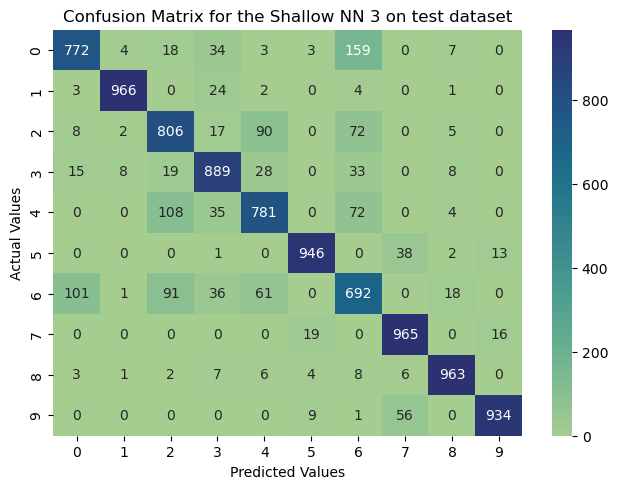

In [163]:
snn3_prediction_result_softmax = EvaluateNeuralNetworkModel(shallow_nn_model3, test_images, test_labels, test_labels_onehot, "Shallow NN 3")

### Shallow Neural Network with Data Augumentation, Droplet and Batch Normalization

In [ ]:
# To do

### Shallow Neural Network committee
- Constructing a committee by averaging predictions of the three shallow neural network models

Loss for the Shallow neural network committee on test dataset: 0.3389
Accuracy for the Shallow neural network committee on test dataset: 0.8849
first 10 predicted outputs using committee by averaging predictions: [9 2 1 1 6 1 4 6 5 7]

first 10 true outputs: [9 2 1 1 6 1 4 6 5 7]

              precision    recall  f1-score   support

           0       0.90      0.72      0.80      1000
           1       0.99      0.98      0.98      1000
           2       0.81      0.81      0.81      1000
           3       0.90      0.89      0.90      1000
           4       0.84      0.78      0.81      1000
           5       0.98      0.96      0.97      1000
           6       0.63      0.80      0.70      1000
           7       0.94      0.97      0.96      1000
           8       0.96      0.98      0.97      1000
           9       0.97      0.95      0.96      1000

    accuracy                           0.88     10000
   macro avg       0.89      0.88      0.89     10000
weighted avg  

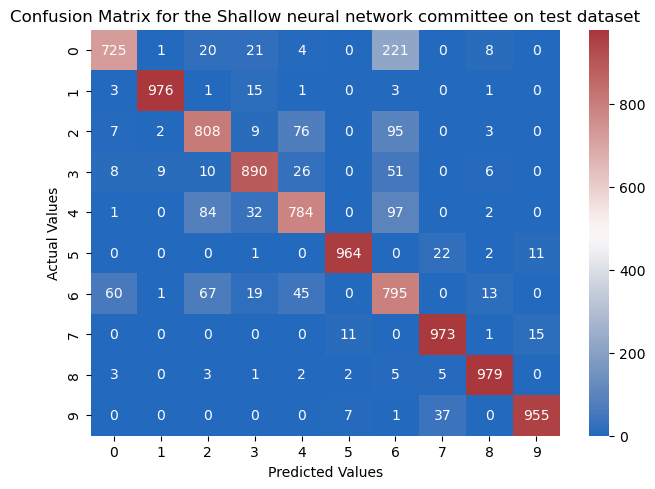

In [164]:
ModelCommitteeAnalysis([
    snn1_prediction_result_softmax, 
    snn2_prediction_result_softmax, 
    snn3_prediction_result_softmax], 
    test_labels, "Shallow")

### Basic Convolutional Neural Network 1

In [ ]:
simple_cnn_model1 = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (28, 28, 1)),
    tf.keras.layers.Conv2D(filters= 32, kernel_size= (3, 3), activation= "relu"),
    tf.keras.layers.MaxPool2D(pool_size= (2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units= 128, activation= "relu"),
    tf.keras.layers.Dense(10, activation='softmax')
])

simple_cnn_model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

simple_cnn1_history = simple_cnn_model1.fit(train_images, train_labels_onehot, epochs=100, validation_split= 0.2, batch_size= 32)

Epoch 1/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.8178 - loss: 0.5234 - val_accuracy: 0.8680 - val_loss: 0.3693
Epoch 2/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8838 - loss: 0.3136 - val_accuracy: 0.8780 - val_loss: 0.3516
Epoch 3/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9018 - loss: 0.2685 - val_accuracy: 0.8774 - val_loss: 0.3713
Epoch 4/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9122 - loss: 0.2374 - val_accuracy: 0.8846 - val_loss: 0.3940
Epoch 5/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9219 - loss: 0.2172 - val_accuracy: 0.8752 - val_loss: 0.4894
Epoch 6/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9257 - loss: 0.2053 - val_accuracy: 0.8773 - val_loss: 0.5058
Epoch 7/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9311 - loss: 0.1913 - val_accuracy: 0.8783 - val_loss: 0.5495
Epoch 8/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9352 - loss: 

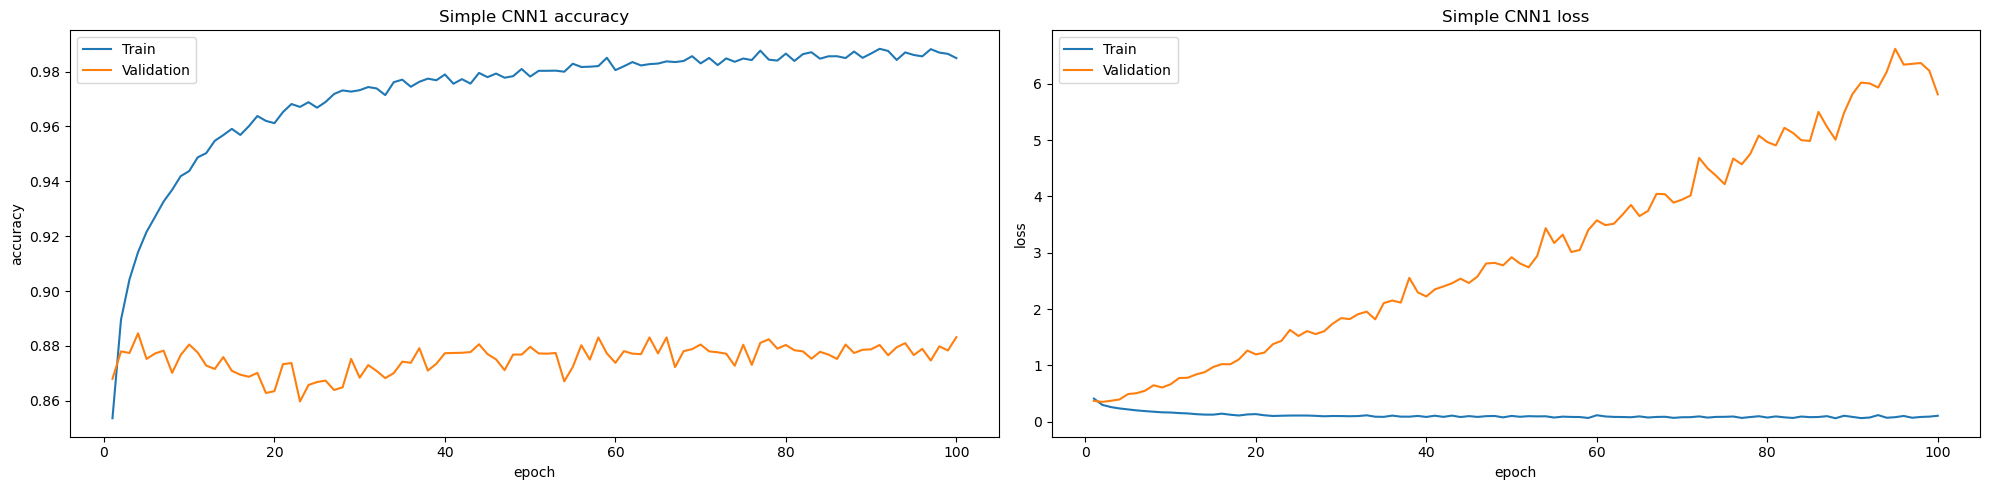

In [56]:
PlotTrainAndValidationAccuracyAndLoss(simple_cnn1_history, "Simple CNN1")

313/313 - 1s - 3ms/step - accuracy: 0.8761 - loss: 6.4665

Test accuracy for Simple CNN 1: 0.8761000037193298

Test loss for Simple CNN 1: 6.46645450592041

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
first 10 predicted outputs: [9 2 1 1 2 1 2 6 5 7]

first 10 true outpurs: [9 2 1 1 6 1 4 6 5 7]

              precision    recall  f1-score   support

           0       0.83      0.77      0.80      1000
           1       0.98      0.97      0.98      1000
           2       0.74      0.82      0.78      1000
           3       0.91      0.86      0.88      1000
           4       0.79      0.79      0.79      1000
           5       0.99      0.98      0.98      1000
           6       0.67      0.70      0.68      1000
           7       0.94      0.97      0.95      1000
           8       0.98      0.97      0.97      1000
           9       0.97      0.94      0.96      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
w

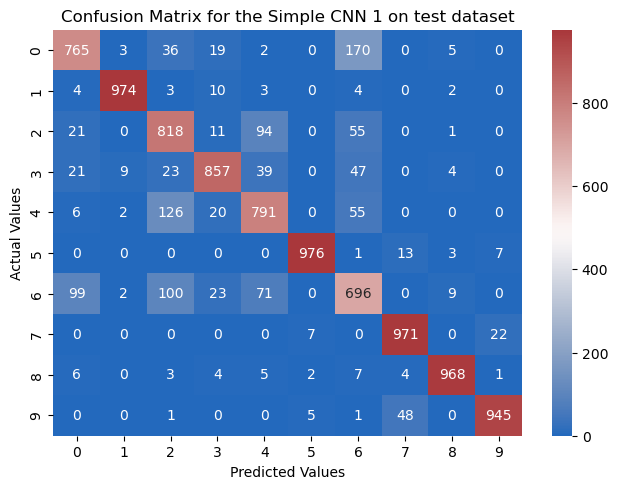

In [73]:
simple_cnn1_prediction_result_softmax = EvaluateNeuralNetworkModel(simple_cnn_model1, test_images, test_labels, test_labels_onehot, "Simple CNN 1")

In [ ]:
simple_cnn_model2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (28, 28, 1)),
    tf.keras.layers.Conv2D(filters= 64, kernel_size= (3, 3), activation= "relu"),
    tf.keras.layers.MaxPool2D(pool_size= (3, 3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units= 256, activation= "relu"),
    tf.keras.layers.Dense(10, activation='softmax')
])

simple_cnn_model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

simple_cnn2_history = simple_cnn_model2.fit(train_images, train_labels_onehot, epochs=100, validation_split= 0.2, batch_size= 64)

Epoch 1/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.7873 - loss: 0.6037 - val_accuracy: 0.8813 - val_loss: 0.3350
Epoch 2/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8863 - loss: 0.3217 - val_accuracy: 0.8938 - val_loss: 0.2950
Epoch 3/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9011 - loss: 0.2750 - val_accuracy: 0.8990 - val_loss: 0.2742
Epoch 4/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9118 - loss: 0.2413 - val_accuracy: 0.9037 - val_loss: 0.2637
Epoch 5/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9216 - loss: 0.2134 - val_accuracy: 0.9048 - val_loss: 0.2651
Epoch 6/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9294 - loss: 0.1906 - val_accuracy: 0.9053 - val_loss: 0.2710
Epoch 7/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9383 - loss: 0.1689 - val_accuracy: 0.9068 - val_loss: 0.2731
Epoch 8/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9464 - loss: 0.1499 - val_accu

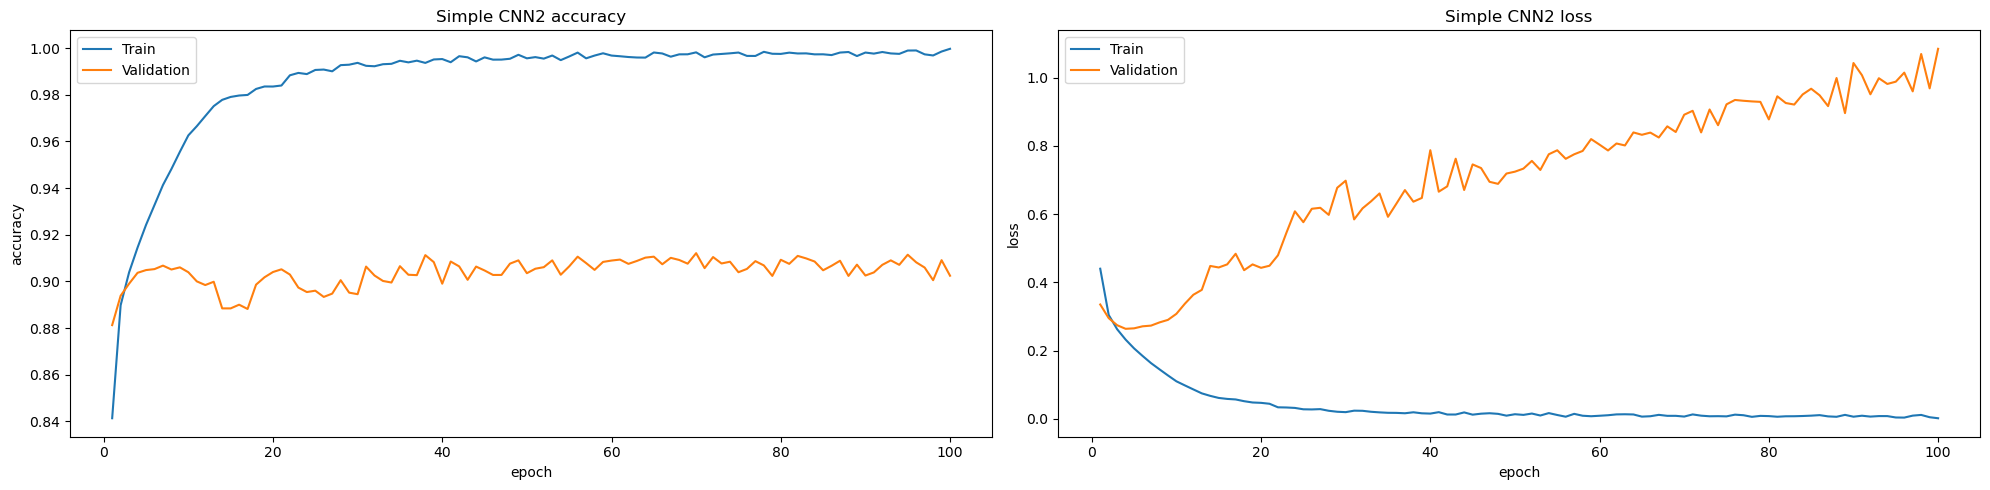

In [57]:
PlotTrainAndValidationAccuracyAndLoss(simple_cnn2_history, "Simple CNN2")

313/313 - 1s - 3ms/step - accuracy: 0.8974 - loss: 1.2107

Test accuracy for Simple CNN 2: 0.8974000215530396

Test loss for Simple CNN 2: 1.2107199430465698

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
first 10 predicted outputs: [9 2 1 1 6 1 4 6 5 7]

first 10 true outpurs: [9 2 1 1 6 1 4 6 5 7]

              precision    recall  f1-score   support

           0       0.82      0.86      0.84      1000
           1       0.99      0.98      0.98      1000
           2       0.82      0.86      0.84      1000
           3       0.92      0.90      0.91      1000
           4       0.77      0.90      0.83      1000
           5       0.98      0.98      0.98      1000
           6       0.77      0.59      0.67      1000
           7       0.95      0.97      0.96      1000
           8       0.98      0.98      0.98      1000
           9       0.97      0.96      0.97      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000

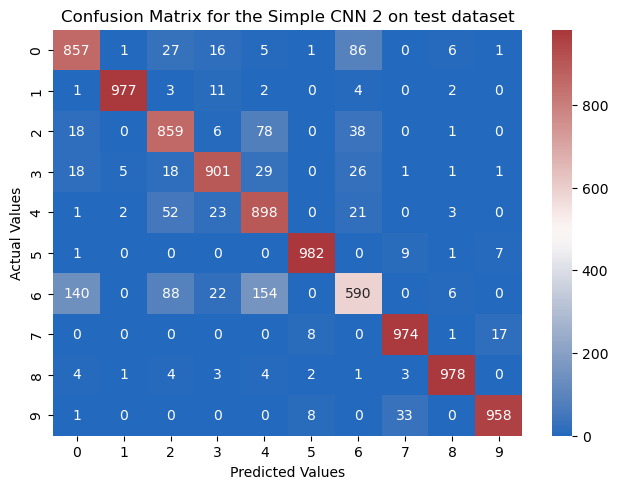

In [74]:
simple_cnn2_prediction_result_softmax = EvaluateNeuralNetworkModel(simple_cnn_model2, test_images, test_labels, test_labels_onehot, "Simple CNN 2")

In [ ]:
simple_cnn_model3 = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (28, 28, 1)),
    tf.keras.layers.Conv2D(filters= 32, kernel_size= (3, 3), activation= "relu"),
    tf.keras.layers.MaxPool2D(pool_size= (2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units= 256, activation= "tanh"),
    tf.keras.layers.Dense(10, activation='softmax')
])

simple_cnn_model3.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.005),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

simple_cnn3_history = simple_cnn_model3.fit(train_images, train_labels_onehot, epochs=100, validation_split= 0.2, batch_size= 64)

Epoch 1/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.5741 - loss: 1.3542 - val_accuracy: 0.7840 - val_loss: 0.6340
Epoch 2/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7882 - loss: 0.6129 - val_accuracy: 0.8073 - val_loss: 0.5439
Epoch 3/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8101 - loss: 0.5352 - val_accuracy: 0.8190 - val_loss: 0.5063
Epoch 4/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8215 - loss: 0.4982 - val_accuracy: 0.8275 - val_loss: 0.4830
Epoch 5/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8307 - loss: 0.4740 - val_accuracy: 0.8332 - val_loss: 0.4662
Epoch 6/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8386 - loss: 0.4562 - val_accuracy: 0.8397 - val_loss: 0.4530
Epoch 7/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8435 - loss: 0.4417 - val_accuracy: 0.8429 - val_loss: 0.4420
Epoch 8/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8482 - loss: 0.4297 - val_accu

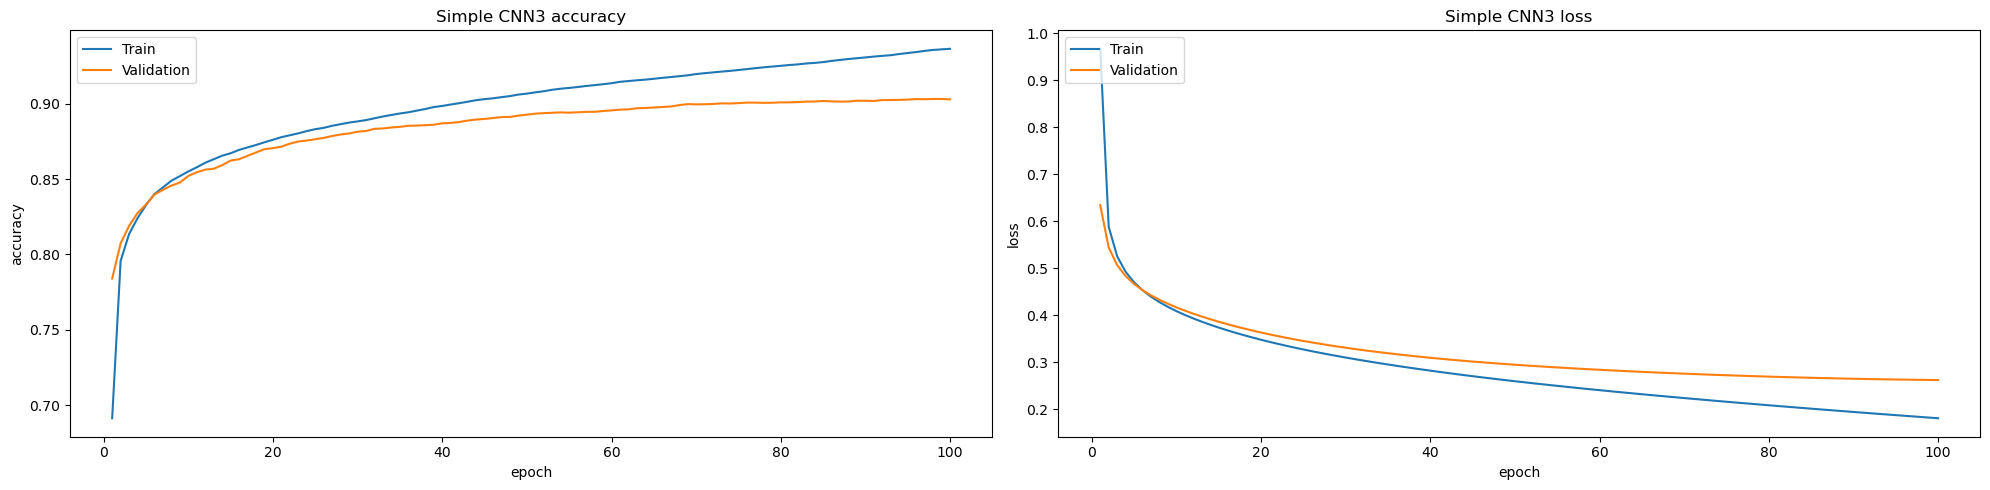

In [58]:
PlotTrainAndValidationAccuracyAndLoss(simple_cnn3_history, "Simple CNN3")

313/313 - 1s - 3ms/step - accuracy: 0.8980 - loss: 0.2810

Test accuracy for Simple CNN 3: 0.8980000019073486

Test loss for Simple CNN 3: 0.280950129032135

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
first 10 predicted outputs: [9 2 1 1 6 1 4 6 5 7]

first 10 true outpurs: [9 2 1 1 6 1 4 6 5 7]

              precision    recall  f1-score   support

           0       0.88      0.82      0.85      1000
           1       0.99      0.97      0.98      1000
           2       0.80      0.87      0.83      1000
           3       0.90      0.92      0.91      1000
           4       0.87      0.80      0.84      1000
           5       0.97      0.96      0.97      1000
           6       0.72      0.74      0.73      1000
           7       0.92      0.97      0.94      1000
           8       0.97      0.97      0.97      1000
           9       0.98      0.94      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000


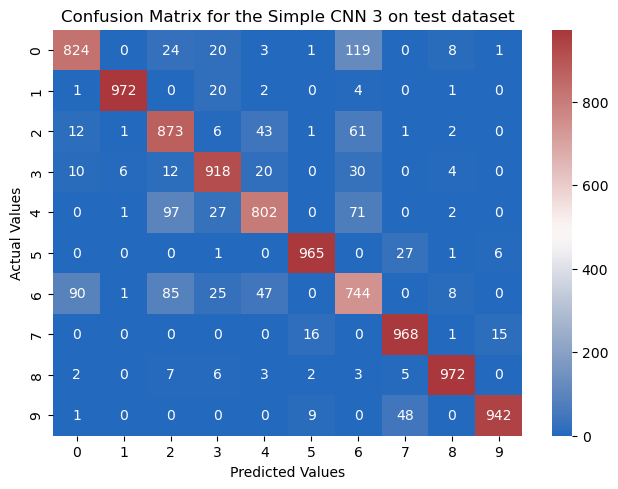

In [75]:
simple_cnn3_prediction_result_softmax = EvaluateNeuralNetworkModel(simple_cnn_model3, test_images, test_labels, test_labels_onehot, "Simple CNN 3")

### Simple CNN committee

Loss for the Simple Convolution neural network committee on test dataset: 0.2671
Accuracy for the Simple Convolution neural network committee on test dataset: 0.9113
first 10 predicted outputs using committee by averaging predictions: [9 2 1 1 6 1 4 6 5 7]

first 10 true outputs: [9 2 1 1 6 1 4 6 5 7]

              precision    recall  f1-score   support

           0       0.86      0.84      0.85      1000
           1       0.99      0.98      0.99      1000
           2       0.83      0.88      0.86      1000
           3       0.92      0.92      0.92      1000
           4       0.83      0.88      0.85      1000
           5       0.99      0.98      0.98      1000
           6       0.78      0.71      0.74      1000
           7       0.95      0.98      0.97      1000
           8       0.99      0.98      0.98      1000
           9       0.98      0.96      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91   

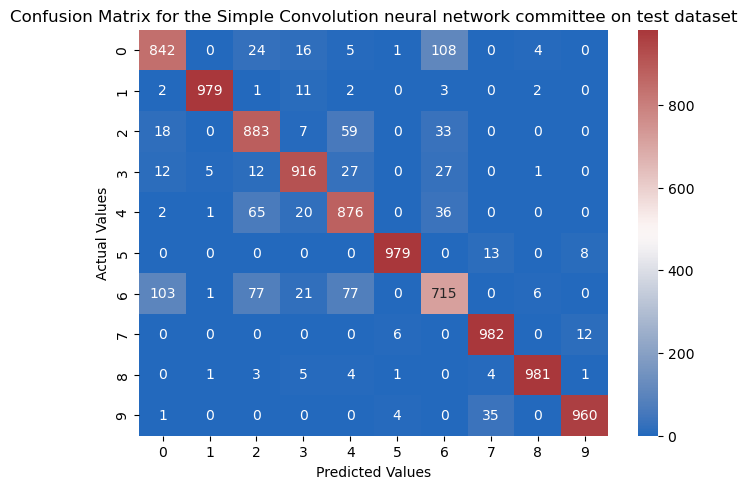

In [35]:
ModelCommitteeAnalysis(
    [simple_cnn1_prediction_result_softmax, 
     simple_cnn2_prediction_result_softmax, 
     simple_cnn3_prediction_result_softmax], 
    test_labels, "Simple Convolution")

## Deep Convolution Neural Network

### Deep CNN 1

In [ ]:
deep_cnn_model1 = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (28, 28, 1)),
    tf.keras.layers.Conv2D(filters= 32, kernel_size= (3, 3), activation= "relu"),
    tf.keras.layers.MaxPool2D(pool_size= (2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units= 256, activation= "tanh"),
    tf.keras.layers.Dense(10, activation='softmax')
])

deep_cnn_model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

deep_cnn1_history = deep_cnn_model1.fit(train_images, train_labels_onehot, epochs=100, validation_split= 0.2, batch_size= 64)

Epoch 1/100


/home/buddha-thapa-magar/anaconda3/envs/ml/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:593: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.4578 - loss: 1.7253 - val_accuracy: 0.7327 - val_loss: 0.7765
Epoch 2/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7251 - loss: 0.7541 - val_accuracy: 0.7650 - val_loss: 0.6524
Epoch 3/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7567 - loss: 0.6522 - val_accuracy: 0.7814 - val_loss: 0.5922
Epoch 4/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7780 - loss: 0.5950 - val_accuracy: 0.7947 - val_loss: 0.5514
Epoch 5/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7915 - loss: 0.5538 - val_accuracy: 0.8065 - val_loss: 0.5217
Epoch 6/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8038 - loss: 0.5223 - val_accuracy: 0.8156 - val_loss: 0.4987
Epoch 7/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8141 - loss: 0.4973 - val_accuracy: 0.8227 - val_loss: 0.4805
Epoch 8/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8225 - loss: 0.4772 - val_accuracy: 0.8278

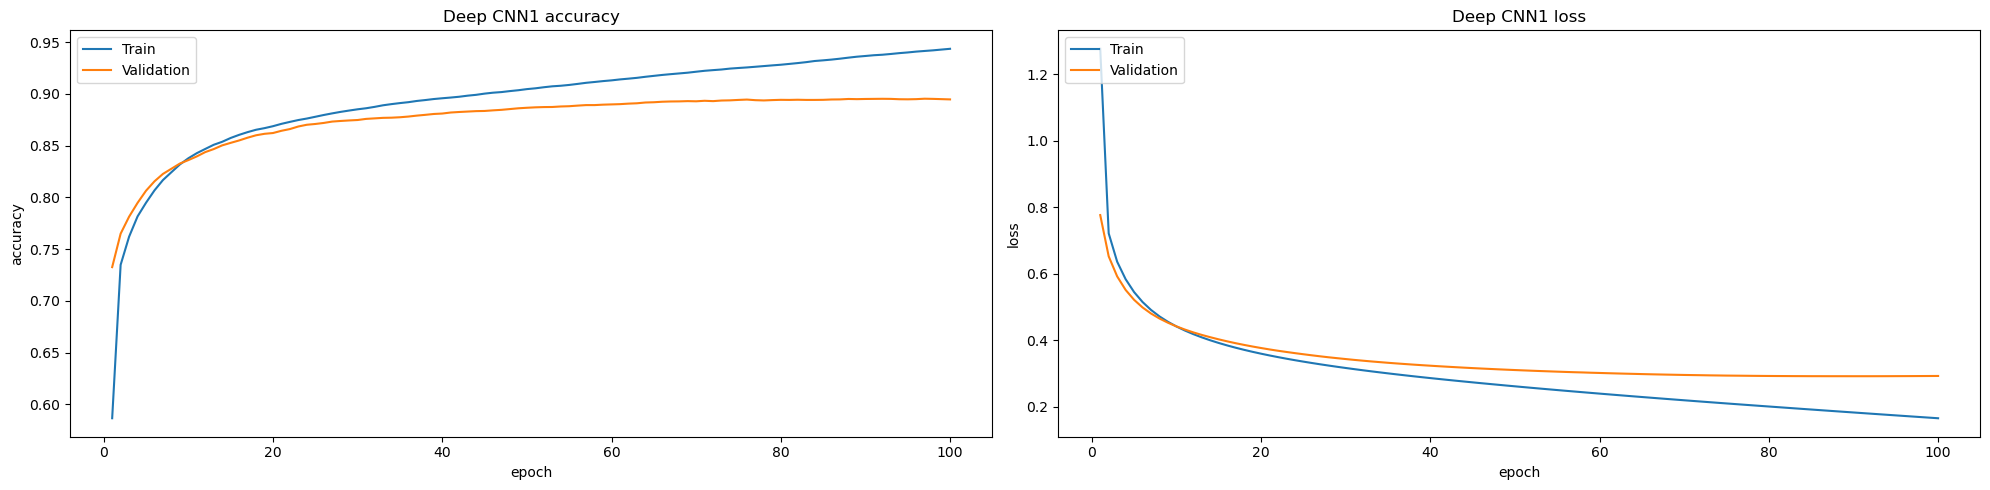

In [59]:
PlotTrainAndValidationAccuracyAndLoss(deep_cnn1_history, "Deep CNN1")

313/313 - 1s - 3ms/step - accuracy: 0.8910 - loss: 0.3003

Test accuracy for Deep CNN 1: 0.890999972820282

Test loss for Deep CNN 1: 0.30028435587882996

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
first 10 predicted outputs: [9 2 1 1 6 1 4 6 5 7]

first 10 true outpurs: [9 2 1 1 6 1 4 6 5 7]

              precision    recall  f1-score   support

           0       0.86      0.82      0.84      1000
           1       0.99      0.98      0.98      1000
           2       0.80      0.85      0.83      1000
           3       0.90      0.89      0.90      1000
           4       0.82      0.81      0.82      1000
           5       0.97      0.96      0.97      1000
           6       0.70      0.69      0.70      1000
           7       0.92      0.97      0.95      1000
           8       0.97      0.98      0.98      1000
           9       0.97      0.94      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
wei

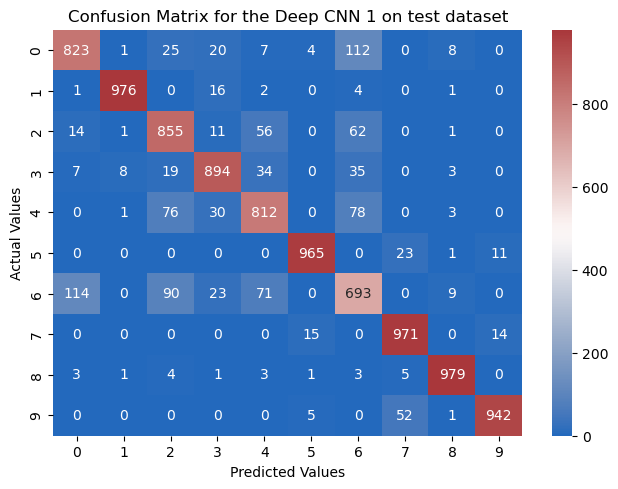

In [76]:
deep_cnn1_prediction_result_softmax = EvaluateNeuralNetworkModel(deep_cnn_model1, test_images, test_labels, test_labels_onehot, "Deep CNN 1")

### Deep CNN Model 2

In [39]:
deep_cnn_model2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (28, 28, 1)),
    tf.keras.layers.Conv2D(filters= 32, kernel_size= (3, 3), activation= "relu"),
    tf.keras.layers.MaxPool2D(pool_size= (2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units= 256, activation= "tanh"),
    tf.keras.layers.Dense(10, activation='softmax')
])

deep_cnn_model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

deep_cnn2_history = deep_cnn_model2.fit(train_images, train_labels_onehot, epochs=100, validation_split= 0.2, batch_size= 64)

Epoch 1/100


/home/buddha-thapa-magar/anaconda3/envs/ml/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:593: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.6822 - loss: 0.8642 - val_accuracy: 0.8391 - val_loss: 0.4350
Epoch 2/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8437 - loss: 0.4272 - val_accuracy: 0.8672 - val_loss: 0.3678
Epoch 3/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8670 - loss: 0.3600 - val_accuracy: 0.8729 - val_loss: 0.3430
Epoch 4/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8820 - loss: 0.3190 - val_accuracy: 0.8792 - val_loss: 0.3370
Epoch 5/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8933 - loss: 0.2886 - val_accuracy: 0.8789 - val_loss: 0.3363
Epoch 6/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9019 - loss: 0.2627 - val_accuracy: 0.8843 - val_loss: 0.3248
Epoch 7/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9099 - loss: 0.2387 - val_accuracy: 0.8862 - val_loss: 0.3226
Epoch 8/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9195 - loss: 0.2182 - val_accuracy: 0.8868

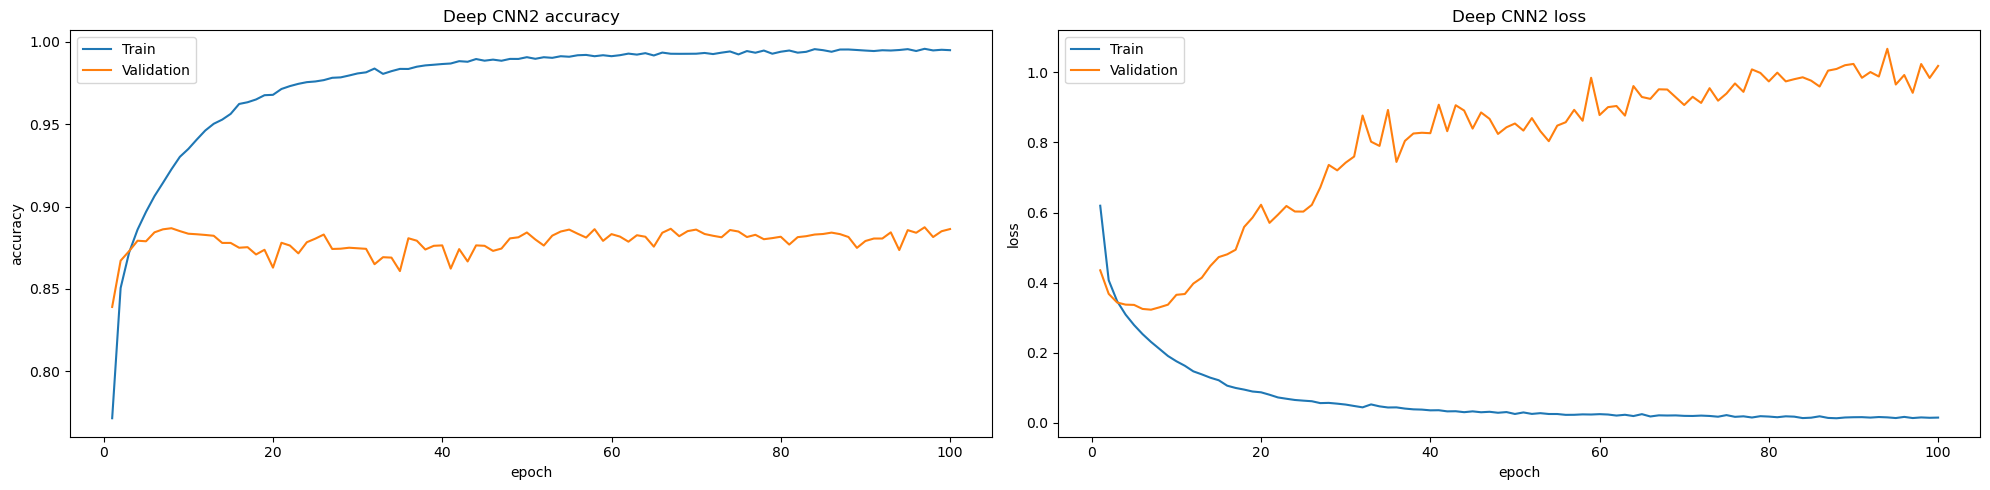

In [60]:
PlotTrainAndValidationAccuracyAndLoss(deep_cnn2_history, "Deep CNN2")

313/313 - 1s - 3ms/step - accuracy: 0.8854 - loss: 1.0589

Test accuracy for Deep CNN 2: 0.8853999972343445

Test loss for Deep CNN 2: 1.0589196681976318

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
first 10 predicted outputs: [9 2 1 1 6 1 4 6 5 7]

first 10 true outpurs: [9 2 1 1 6 1 4 6 5 7]

              precision    recall  f1-score   support

           0       0.84      0.83      0.83      1000
           1       0.99      0.97      0.98      1000
           2       0.79      0.84      0.82      1000
           3       0.88      0.91      0.89      1000
           4       0.80      0.86      0.83      1000
           5       0.98      0.95      0.97      1000
           6       0.72      0.62      0.66      1000
           7       0.92      0.96      0.94      1000
           8       0.97      0.97      0.97      1000
           9       0.96      0.94      0.95      1000

    accuracy                           0.89     10000
   macro avg       0.88      0.89      0.88     10000
wei

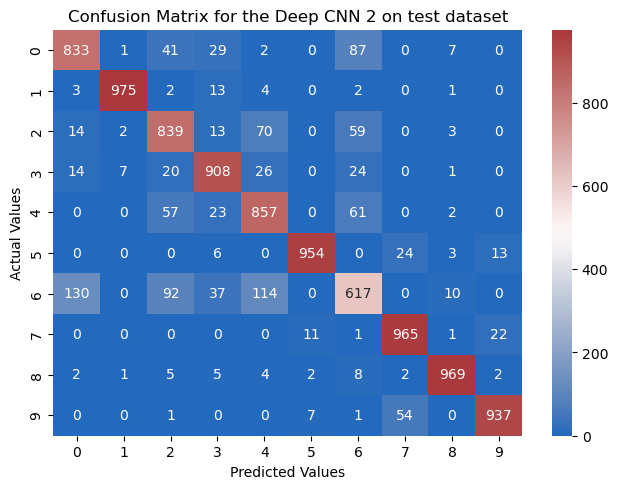

In [77]:
deep_cnn2_prediction_result_softmax = EvaluateNeuralNetworkModel(deep_cnn_model2, test_images, test_labels, test_labels_onehot, "Deep CNN 2")

### Deep CNN Model 3

In [ ]:
deep_cnn_model3 = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (28, 28, 1)),
    tf.keras.layers.Conv2D(filters= 32, kernel_size= (3, 3), activation= "relu"),
    tf.keras.layers.MaxPool2D(pool_size= (2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units= 256, activation= "tanh"),
    tf.keras.layers.Dense(10, activation='softmax')
])

deep_cnn_model3.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.005),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

deep_cnn3_history = deep_cnn_model3.fit(train_images, train_labels_onehot, epochs=100, validation_split= 0.2, batch_size= 64)

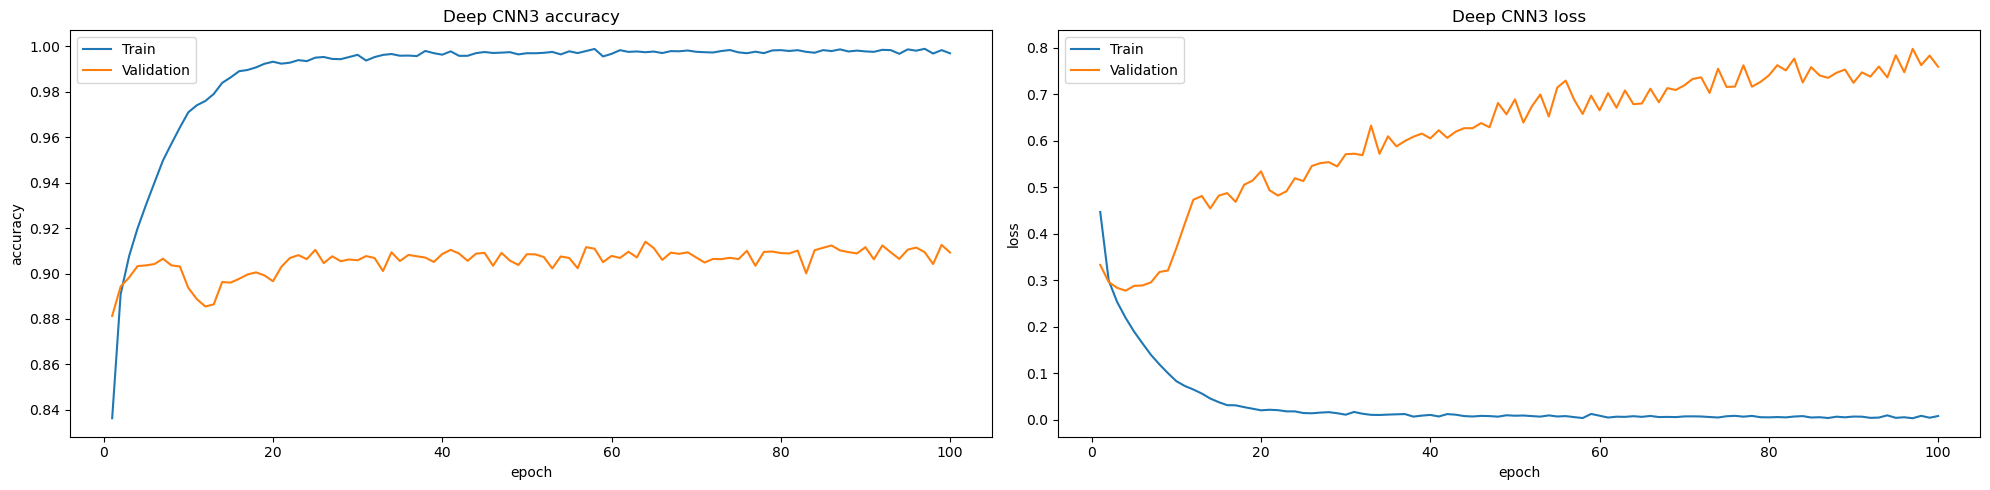

In [61]:
PlotTrainAndValidationAccuracyAndLoss(deep_cnn3_history, "Deep CNN3")

313/313 - 1s - 3ms/step - accuracy: 0.9056 - loss: 0.7681

Test accuracy for Deep CNN 3: 0.9056000113487244

Test loss for Deep CNN 3: 0.7680823802947998

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
first 10 predicted outputs: [9 2 1 1 6 1 4 6 5 7]

first 10 true outpurs: [9 2 1 1 6 1 4 6 5 7]

              precision    recall  f1-score   support

           0       0.85      0.85      0.85      1000
           1       0.98      0.98      0.98      1000
           2       0.87      0.84      0.85      1000
           3       0.92      0.90      0.91      1000
           4       0.84      0.88      0.86      1000
           5       0.98      0.98      0.98      1000
           6       0.72      0.72      0.72      1000
           7       0.94      0.97      0.96      1000
           8       0.98      0.98      0.98      1000
           9       0.98      0.95      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
wei

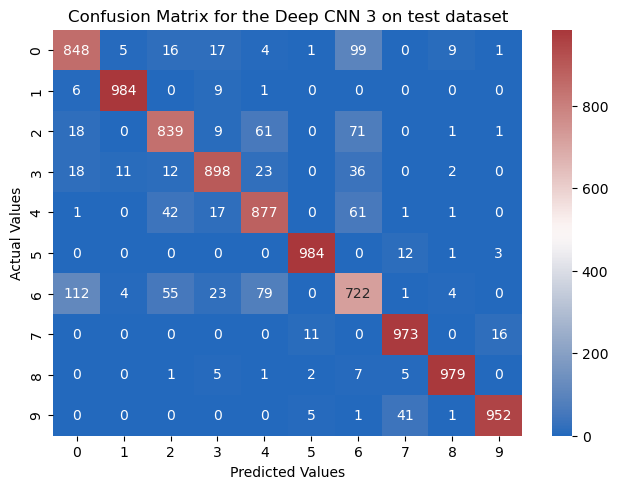

In [78]:
deep_cnn3_prediction_result_softmax = EvaluateNeuralNetworkModel(deep_cnn_model3, test_images, test_labels, test_labels_onehot, "Deep CNN 3")

### Deep CNN Model Committee

Loss for the Deep CNN neural network committee on test dataset: 1.5637
Accuracy for the Deep CNN neural network committee on test dataset: 0.9159
first 10 predicted outputs using committee by averaging predictions: [9 2 1 1 6 1 4 6 5 7]

first 10 true outputs: [9 2 1 1 6 1 4 6 5 7]

              precision    recall  f1-score   support

           0       0.86      0.86      0.86      1000
           1       0.99      0.98      0.98      1000
           2       0.85      0.88      0.87      1000
           3       0.92      0.92      0.92      1000
           4       0.86      0.89      0.87      1000
           5       0.99      0.98      0.98      1000
           6       0.78      0.73      0.75      1000
           7       0.95      0.98      0.96      1000
           8       0.98      0.98      0.98      1000
           9       0.98      0.95      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg

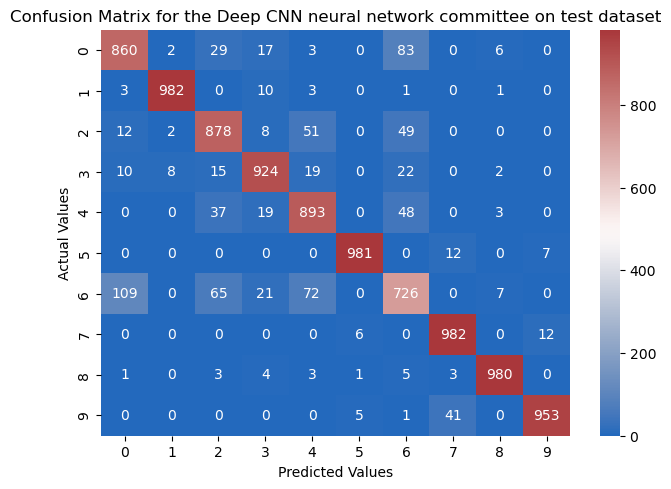

In [45]:
ModelCommitteeAnalysis(
    [deep_cnn1_prediction_result_softmax, 
     deep_cnn2_prediction_result_softmax, 
     deep_cnn3_prediction_result_softmax],
     test_labels,
     "Deep CNN"
)